# 基于时间序列的分类

In [14]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import timedelta
from numpy import ndarray
from typing import Union, List, Dict
from sklearn.preprocessing import MinMaxScaler
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn.functional as F
from tqdm import tqdm  # 打印进度条
import math
import matplotlib.pyplot as plt
from typing import List
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import warnings

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文标签
plt.rcParams['axes.unicode_minus'] = False

## 基础知识

模型基于CrossEntropyLoss损失来训练时序分类模型，**注意输入数据特征不包含时间特征和分类特征**。时序分类训练流程类似于图像分类模型的训练流程。

## TimesNet分类

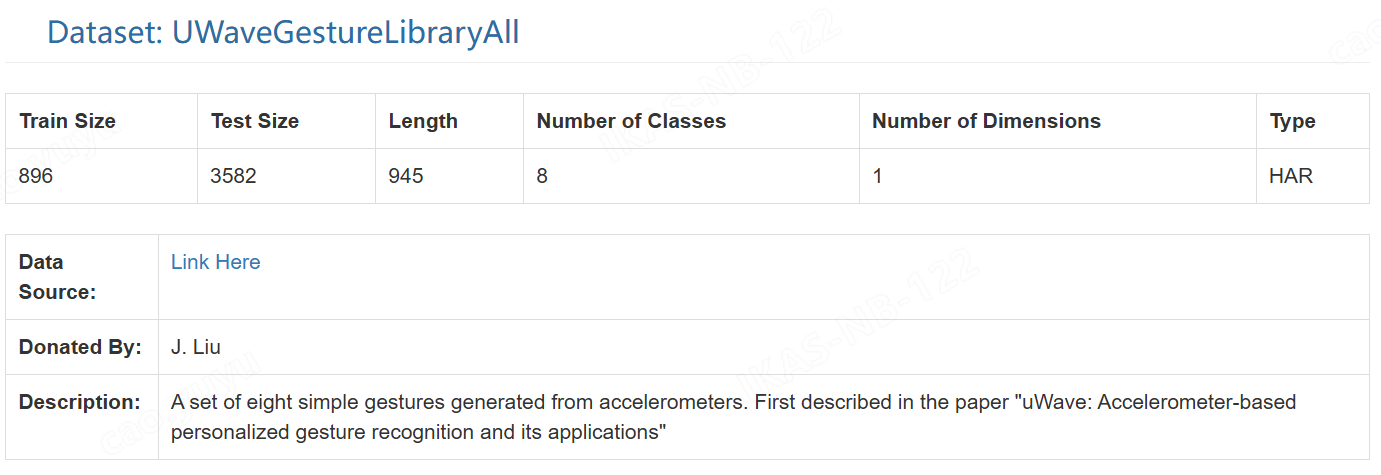

### 数据读取

In [5]:
data_path = "../data/UWaveGestureLibraryAll_TRAIN.tsv"
data = pd.read_csv(data_path, sep='\t', header=None)
data

,0,1,2,3,4,5,6,7,8,9,...,936,937,938,939,940,941,942,943,944,945
0,6,-0.312502,-0.312502,-0.312502,-0.312502,-0.312502,-0.312502,-0.312502,-0.312502,-0.312502,...,0.512194,0.503002,0.492524,0.482045,0.463662,0.445278,0.426895,0.408511,0.390129,0.371746
1,5,1.629721,1.629721,1.629721,1.629721,1.629721,1.629721,1.629721,1.629721,1.629721,...,-0.424252,-0.424252,-0.424252,-0.424414,-0.426015,-0.437960,-0.449905,-0.461849,-0.473794,-0.485739
2,5,0.665410,0.665410,0.665410,0.665410,0.665410,0.665410,0.665410,0.665410,0.665410,...,-0.856895,-0.856895,-0.856895,-0.856895,-0.856895,-0.856895,-0.856895,-0.856895,-0.856895,-0.856895
3,3,0.164887,0.164887,0.164887,0.164887,0.164887,0.164887,0.164887,0.164887,0.164887,...,-0.194748,-0.131015,-0.286569,0.051284,0.389136,0.149143,0.245672,0.437129,0.639840,0.842551
4,4,1.272493,1.272493,1.272493,1.272493,1.272493,1.272493,1.272493,1.272493,1.272493,...,1.852405,1.819330,1.741195,1.624052,1.506909,1.439170,1.500978,1.618121,1.735263,1.852405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,3,0.126056,0.126056,0.126056,0.126056,0.126056,0.126056,0.126056,0.126056,0.126056,...,-0.202822,-0.128241,-0.321706,-0.044231,0.142222,0.328674,0.110026,0.147317,0.184607,0.221897
892,1,-1.232312,-1.232312,-1.232312,-1.232312,-1.232312,-1.232312,-1.232312,-1.232312,-1.232312,...,0.221684,0.233878,0.246070,0.258264,0.270456,0.282650,0.294843,0.307036,0.319229,0.331423
893,2,0.285103,0.285103,0.285103,0.285103,0.285103,0.285103,0.285103,0.285103,0.285103,...,-0.219075,-0.213164,-0.187128,0.176418,0.138347,0.198371,0.446330,0.161218,0.225716,0.270101
894,7,1.251416,1.251416,1.251416,1.251416,1.251416,1.251416,1.251416,1.251416,1.251416,...,-0.155403,-0.158187,-0.185514,-0.291492,-0.401972,-0.499320,-0.553890,-0.544005,-0.500638,-0.427876


In [6]:
# 重构数据
def reconstruction(data, columns):
    """
    重构数据

    参数说明
    ----------
    data : {list[pd.Dataframe]} 
        输入数据
    columns : {list[str]} 
        每张表对应一个特征

    返回值
    -------
    df0 : {DataFrame} of shape (n_samples, n_features)
        将所有数据合并成行为时间，列为特征的格式
    """
    for i in range(len(data)):
        if i == 0:
            df0 = pd.DataFrame(data=None, columns=[columns[i]])
            for j in range(data[i].T.shape[1]):
                df0 = pd.concat([
                    df0,
                    pd.DataFrame(np.array([data[i].T.iloc[:, j].values]).T,
                                 columns=[columns[i]])
                ],
                               axis=0)
            df0 = df0.reset_index(drop=True)
        else:
            df1 = pd.DataFrame(data=None, columns=[columns[i]])
            for j in range(data[i].T.shape[1]):
                df1 = pd.concat([
                    df1,
                    pd.DataFrame(np.array([data[i].T.iloc[:, j].values]).T,
                                 columns=[columns[i]])
                ],
                               axis=0)
            df1 = df1.reset_index(drop=True)
            df0 = pd.concat([df0, df1], axis=1)

    return df0

In [7]:
# 构造参数字典
params1 = {
    "data": [data.iloc[:, 1:]],
    "columns": ['uWave'],
}

#函数传参
re_data = reconstruction(**params1)
print("x shape: {0}".format(re_data.shape))

x shape: (846720, 1)


In [8]:
# 数据归一化
def normalize(df, x_feature_list, scaler_path):
    """
    读取数据，并对数据进行归一化

    参数说明
    ----------
    df : {DataFrame} of shape (n_samples, n_features)
        输入数据
    x_feature_list : {list[str]} 
        训练特征列，不包含时间列
    scaler_path : {str} 
        数据归一化模型保存地址

    返回值
    -------
    x_scaler : {sklearn.preprocessing.MinMaxScaler}
        训练特征列归一化器
    df : {list[DataFrame]}
        结果数据
    """
    #归一化训练
    x_scaler = MinMaxScaler() # 保证数据同分布
    x = df.copy()[x_feature_list]
    x_scaler = x_scaler.fit(x) 

    # 设置保存归一化参数路径
    if not os.path.exists(scaler_path):
        os.makedirs(scaler_path)

    # 保存归一化参数
    joblib.dump(x_scaler, scaler_path + "/x_scaler.pkl")

    # 归一化
    x[x_feature_list] = x_scaler.transform(x)
    df = x.values.astype('float32')
    
    return x_scaler, df

In [9]:
# 构造参数字典
params2 = {
    "df": re_data,
    "x_feature_list": ['uWave'],
    "scaler_path": '../outputs/scalers/TimesNet_C'
}

#函数传参
x_scaler, norm_data = normalize(**params2)
print("x shape: {0}".format(norm_data.shape))

x shape: (846720, 1)


In [10]:
# 还原数据集
def reduction(feature, target):
    """
    读取数据，并对数据进行归一化

    参数说明
    ----------
    feature : {DataFrame} of shape (n_samples, n_features)
        归一化后的数据
    target : {list[str]} 
        标签列

    返回值
    -------
    redu_data : {DataFrame} of shape (n_samples, n_features+1)
        还原为输入数据的格式

    """
    redu_data = []
    for i in range(feature.shape[1]):
        np_data = np.concatenate([
            target.reshape(len(target), -1),
            feature.reshape(len(target), -1)
        ],
                                 axis=1)
        pd_data = pd.DataFrame(np_data)
        redu_data.append(pd_data)

    return redu_data

In [11]:
# 构造参数字典
params3 = {
    "feature": norm_data,
    "target": data.iloc[:, 0].values,
}

#函数传参
redu_data = reduction(**params3)
print("x len: {0}".format(len(redu_data)))

x len: 1


In [12]:
redu_data[0]

,0,1,2,3,4,5,6,7,8,9,...,936,937,938,939,940,941,942,943,944,945
0,6.0,0.341678,0.341678,0.341678,0.341678,0.341678,0.341678,0.341678,0.341678,0.341678,...,0.410047,0.409285,0.408417,0.407548,0.406024,0.404500,0.402976,0.401452,0.399928,0.398404
1,5.0,0.502693,0.502693,0.502693,0.502693,0.502693,0.502693,0.502693,0.502693,0.502693,...,0.332414,0.332414,0.332414,0.332401,0.332268,0.331278,0.330287,0.329297,0.328307,0.327317
2,5.0,0.422749,0.422749,0.422749,0.422749,0.422749,0.422749,0.422749,0.422749,0.422749,...,0.296547,0.296547,0.296547,0.296547,0.296547,0.296547,0.296547,0.296547,0.296547,0.296547
3,3.0,0.381255,0.381255,0.381255,0.381255,0.381255,0.381255,0.381255,0.381255,0.381255,...,0.351440,0.356724,0.343828,0.371837,0.399846,0.379950,0.387952,0.403824,0.420630,0.437435
4,4.0,0.473078,0.473078,0.473078,0.473078,0.473078,0.473078,0.473078,0.473078,0.473078,...,0.521154,0.518412,0.511934,0.502223,0.492511,0.486896,0.492020,0.501731,0.511442,0.521154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,3.0,0.378036,0.378036,0.378036,0.378036,0.378036,0.378036,0.378036,0.378036,0.378036,...,0.350771,0.356954,0.340915,0.363919,0.379376,0.394833,0.376707,0.379798,0.382890,0.385981
892,1.0,0.265424,0.265424,0.265424,0.265424,0.265424,0.265424,0.265424,0.265424,0.265424,...,0.385964,0.386974,0.387985,0.388996,0.390007,0.391018,0.392029,0.393039,0.394050,0.395061
893,2.0,0.391221,0.391221,0.391221,0.391221,0.391221,0.391221,0.391221,0.391221,0.391221,...,0.349424,0.349914,0.352072,0.382211,0.379055,0.384031,0.404587,0.380951,0.386298,0.389977
894,7.0,0.471331,0.471331,0.471331,0.471331,0.471331,0.471331,0.471331,0.471331,0.471331,...,0.354702,0.354471,0.352206,0.343420,0.334261,0.326191,0.321667,0.322486,0.326082,0.332114


In [15]:
# 构造数据集
class TensorDataset(Dataset):
    def __init__(self, data, columns):
        df, labels = self.load_all(data, columns)
        self.all_df, self.labels_df = self.load_single(df, labels)
        self.all_IDs = self.all_df.index.unique()  # all sample IDs (integer indices 0 ... num_samples-1)

        # use all features
        self.feature_names = self.all_df.columns
        self.feature_df = self.all_df

    # 加载多个数据集
    # df是一个dataframe，每一列代表一个时间特征，每个时间特征由列表构成，代表时间步的数据，可以不等长，每一行代表样本数
    def load_all(self, data: List[pd.DataFrame], columns: List[str]):
        # 特征数据合并
        for i in range(len(data)):
            if i == 0:
                df = data[i].iloc[:, 1:]
                # row.tolist()将这一行的所有列值提取并转换为一个普通的 Python 列表
                df = pd.DataFrame(df.apply(lambda row: row.tolist(), axis=1),
                                  columns=[columns[i]])
            else:
                df2 = data[i].iloc[:, 1:]
                df2 = pd.DataFrame(df2.apply(lambda row: row.tolist(), axis=1),
                                   columns=[columns[i]])
                df = pd.concat([df, df2], axis=1)

        # 标签数据
        labels = data[0].iloc[:, 0].values.astype('int')

        return df, labels

    # 加载单个数据集
    def load_single(self, df, labels):
        labels = pd.Series(labels, dtype="category")
        self.class_names = labels.cat.categories
        labels_df = pd.DataFrame(labels.cat.codes,
                                 dtype=np.int8)  # 类别组成的数据框，类别从0开始

        lengths = df.applymap(
            lambda x: len(x)).values  # (num_samples, num_dimensions) array containing the length of each series

        horiz_diffs = np.abs(lengths - np.expand_dims(lengths[:, 0], -1))

        if np.sum(horiz_diffs) > 0:  # if any row (sample) has varying length across dimensions
            df = df.applymap(self.subsample)

        lengths = df.applymap(lambda x: len(x)).values
        vert_diffs = np.abs(lengths - np.expand_dims(lengths[0, :], 0))
        if np.sum(vert_diffs) > 0:  # if any column (dimension) has varying length across samples
            self.max_seq_len = int(np.max(lengths[:, 0]))
        else:
            self.max_seq_len = lengths[0, 0]

        # First create a (seq_len, feat_dim) dataframe for each sample, indexed by a single integer ("ID" of the sample)
        # Then concatenate into a (num_samples * seq_len, feat_dim) dataframe, with multiple rows corresponding to the
        # sample index (i.e. the same scheme as all datasets in this project)

        df = pd.concat((pd.DataFrame({col: df.loc[row, col] for col in df.columns}).reset_index(drop=True).set_index(
            pd.Series(lengths[row, 0] * [row])) for row in range(df.shape[0])), axis=0)

        # Replace NaN values
        grp = df.groupby(by=df.index)
        df = grp.transform(self.interpolate_missing)

        return df, labels_df
    
    # 通过采样保持序列长度一致
    def subsample(self, y, limit=256, factor=2):
        """
        If a given Series is longer than `limit`, returns subsampled sequence by the specified integer factor
        """
        if len(y) > limit:
            return y[::factor].reset_index(drop=True)
        return y
    
    # 线性插值填充缺失值
    def interpolate_missing(self, y):
        """
        Replaces NaN values in pd.Series `y` using linear interpolation
        """
        if y.isna().any():
            y = y.interpolate(method='linear', limit_direction='both')
        return y

    def __getitem__(self, ind):
        batch_x = self.feature_df.loc[self.all_IDs[ind]].values
        labels = self.labels_df.loc[self.all_IDs[ind]].values
        # 数据增强

        return torch.from_numpy(batch_x), torch.from_numpy(labels)

    def __len__(self):
        return len(self.all_IDs)

In [16]:
# 构造参数字典
params4 = {
    "data": redu_data,
    "columns": ['uWave'],
}

#函数传参
data_set = TensorDataset(**params4)
print("data_set: {0}".format(len(data_set)))

data_set: 896


In [17]:
# 生成掩码，序列不一致时，取最长的，不够最长的序列为False，否则为True
def padding_mask(lengths, max_len=None):
    """
    Used to mask padded positions: creates a (batch_size, max_len) boolean mask from a tensor of sequence lengths,
    where 1 means keep element at this position (time step)
    """
    batch_size = lengths.numel()
    max_len = max_len or lengths.max()  # trick works because of overloading of 'or' operator for non-boolean types
    return (torch.arange(0, max_len, device=lengths.device)
            .type_as(lengths)
            .repeat(batch_size, 1)
            .lt(lengths.unsqueeze(1)))

# 生成特征数据和掩码
def collate_fn(data, max_len=None):
    """Build mini-batch tensors from a list of (X, mask) tuples. Mask input. Create
    Args:
        data: len(batch_size) list of tuples (X, y).
            - X: torch tensor of shape (seq_length, feat_dim); variable seq_length.
            - y: torch tensor of shape (num_labels,) : class indices or numerical targets
                (for classification or regression, respectively). num_labels > 1 for multi-task models
        max_len: global fixed sequence length. Used for architectures requiring fixed length input,
            where the batch length cannot vary dynamically. Longer sequences are clipped, shorter are padded with 0s
    Returns:
        X: (batch_size, padded_length, feat_dim) torch tensor of masked features (input)
        targets: (batch_size, padded_length, feat_dim) torch tensor of unmasked features (output)
        target_masks: (batch_size, padded_length, feat_dim) boolean torch tensor
            0 indicates masked values to be predicted, 1 indicates unaffected/"active" feature values
        padding_masks: (batch_size, padded_length) boolean tensor, 1 means keep vector at this position, 0 means padding
    """

    batch_size = len(data)
    features, labels = zip(*data)

    # Stack and pad features and masks (convert 2D to 3D tensors, i.e. add batch dimension)
    lengths = [X.shape[0] for X in features]  # original sequence length for each time series
    if max_len is None:
        max_len = max(lengths)

    X = torch.zeros(batch_size, max_len, features[0].shape[-1])  # (batch_size, padded_length, feat_dim)
    for i in range(batch_size):
        end = min(lengths[i], max_len)
        X[i, :end, :] = features[i][:end, :]

    targets = torch.stack(labels, dim=0)  # (batch_size, num_labels)

    padding_masks = padding_mask(torch.tensor(lengths, dtype=torch.int16),
                                 max_len=max_len)  # (batch_size, padded_length) boolean tensor, "1" means keep

    return X, targets, padding_masks

In [18]:
# X_shape:(batch_size, seq_len, channel)
# targets_shape:(batch_size, 1)
# padding_masks_shape:(batch_size, seq_len)
data_loader = DataLoader(
    data_set,
    batch_size=16,
    shuffle=True,
    drop_last=False,
    collate_fn=lambda x: collate_fn(x, max_len=data_set.max_seq_len))

### 模型定义

In [19]:
# 位置编码，是对于每一条序列位置的编码，和具体的值无关
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() *
                    -(math.log(10000.0) / d_model)).exp()

        # 注意：d_model需要是偶数
        # 0::2：从0开始，以步长为2进行取值，取到的都是偶数位置
        pe[:, 0::2] = torch.sin(position * div_term)
        # 1::2：从1开始，以步长为2进行取值，取到的都是奇数位置
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        # 作用是该组参数不会更新，但是保存模型时，该组参数又作为模型参数被保存
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


# 使用conv1d的目的是要对序列中的每一个时间点上的数据（也就是token）来做编码
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in,
                                   out_channels=d_model,
                                   kernel_size=3,
                                   padding=padding,
                                   padding_mode='circular',
                                   bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_in',
                                        nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() *
                    -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()


# 是对于时间戳的编码（协变量），和序列本身的位置、数值无关
class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        # freq拆分
        number = re.findall('[0-9]', freq)
        number = 1 if len(number) == 0 else int(''.join(number))
        string = re.findall('[a-z]', freq)[0]
        if string == 'h':
            hour_size = int(24 / number)
        elif string == 't':
            hour_size = 24
            minute_size = int(60 / number)
        elif string == 's':
            hour_size = 24
            minute_size = 60
            second_size = int(60 / number)
        weekday_size = 7
        day_size = 32
        month_size = 13

        Embed = FixedEmbedding if embed_type == 'fixed' else nn.Embedding
        if freq == 't':
            self.minute_embed = Embed(minute_size, d_model)
        if freq == 's':
            self.second_embed = Embed(second_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()
        second_x = self.second_embed(x[:, :, 5]) if hasattr(
            self, 'second_embed') else 0.
        minute_x = self.minute_embed(x[:, :, 4]) if hasattr(
            self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:, :, 3])
        weekday_x = self.weekday_embed(x[:, :, 2])
        day_x = self.day_embed(x[:, :, 1])
        month_x = self.month_embed(x[:, :, 0])

        return hour_x + weekday_x + day_x + month_x + minute_x + second_x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {
            'h': 4,
            't': 5,
            's': 6,
            'm': 1,
            'a': 1,
            'w': 2,
            'd': 3,
            'b': 3
        }
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model, bias=False)

    def forward(self, x):
        return self.embed(x)


class DataEmbedding(nn.Module):
    def __init__(self,
                 c_in,
                 d_model,
                 embed_type='fixed',
                 freq='h',
                 dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(
            d_model=d_model, embed_type=embed_type,
            freq=freq) if embed_type != 'timeF' else TimeFeatureEmbedding(
                d_model=d_model, embed_type=embed_type, freq=freq)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        if x_mark is None:
            x = self.value_embedding(x) + self.position_embedding(x)
        else:
            x = self.value_embedding(x) + self.temporal_embedding(
                x_mark) + self.position_embedding(x)
        return self.dropout(x)


# 将不同的卷积层通过并联的方式结合在一起，经过不同卷积层处理的结果矩阵在深度这个维度拼接起来，形成一个更深的矩阵
class Inception_Block_V1(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 num_kernels=6,
                 init_weight=True):
        super(Inception_Block_V1, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_kernels = num_kernels  # 卷积核尺寸
        kernels = []
        for i in range(self.num_kernels):
            kernels.append(
                nn.Conv2d(in_channels,
                          out_channels,
                          kernel_size=2 * i + 1,
                          padding=i))
        self.kernels = nn.ModuleList(kernels)
        if init_weight:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        res_list = []
        for i in range(self.num_kernels):
            res_list.append(self.kernels[i](x))
        res = torch.stack(res_list, dim=-1).mean(-1)
        return res


# 快速傅里叶变换，返回周期长度和频率
def FFT_for_Period(x, k=2):
    # [B, T, C]
    xf = torch.fft.rfft(x, dim=1)
    # find period by amplitudes
    frequency_list = abs(xf).mean(0).mean(-1)
    frequency_list[0] = 0
    _, top_list = torch.topk(frequency_list, k)
    top_list = top_list.detach().cpu().numpy()
    period = x.shape[1] // top_list
    return period, abs(xf).mean(-1)[:, top_list]


class TimesBlock(nn.Module):
    def __init__(self, seq_len, pred_len, top_k, d_model, d_ff, num_kernels):
        super(TimesBlock, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.k = top_k  # 强度最大的K个频率，不宜过大，容易出现0的情况
        # parameter-efficient design
        self.conv = nn.Sequential(
            Inception_Block_V1(d_model, d_ff, num_kernels=num_kernels),
            nn.GELU(),
            Inception_Block_V1(d_ff, d_model, num_kernels=num_kernels))

    def forward(self, x):
        B, T, C = x.size()
        period_list, period_weight = FFT_for_Period(x, self.k)

        res = []
        for i in range(self.k):
            period = period_list[i]
            # padding
            if (self.seq_len + self.pred_len) % period != 0:
                length = ((
                    (self.seq_len + self.pred_len) // period) + 1) * period
                padding = torch.zeros([
                    x.shape[0], (length - (self.seq_len + self.pred_len)),
                    x.shape[2]
                ]).to(x.device)
                out = torch.cat([x, padding], dim=1)
            else:
                length = (self.seq_len + self.pred_len)
                out = x
            # reshape
            out = out.reshape(B, length // period, period,
                              C).permute(0, 3, 1, 2).contiguous()
            # 2D conv: from 1d Variation to 2d Variation
            out = self.conv(out)
            # reshape back
            out = out.permute(0, 2, 3, 1).reshape(B, -1, C)
            res.append(out[:, :(self.seq_len + self.pred_len), :])
        res = torch.stack(res, dim=-1)
        # 自适应融合
        period_weight = F.softmax(period_weight, dim=1)
        period_weight = period_weight.unsqueeze(1).unsqueeze(1).repeat(
            1, T, C, 1)
        res = torch.sum(res * period_weight, -1)
        # 残差连接
        res = res + x
        return res


# TimesNet模型
class TimesNet(nn.Module):
    def __init__(self, seq_len, pred_len, top_k, d_model, d_ff, num_kernels,
                 e_layers, enc_in, dropout, embed, freq, num_class):
        super(TimesNet, self).__init__()
        self.seq_len = seq_len  # 输入序列长度
        self.pred_len = pred_len  # 输出序列长度
        self.model = nn.ModuleList([
            TimesBlock(self.seq_len, self.pred_len, top_k, d_model, d_ff,
                       num_kernels) for _ in range(e_layers)
        ])
        self.enc_embedding = DataEmbedding(
            enc_in,  # 编码器维度
            d_model,  # 隐藏层维度
            embed,  # 时间特征编码，[timeF, fixed, learned]
            freq,  # 时间特征编码频率，[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly]
            dropout)
        self.layer = e_layers  # TimesBlock层数
        self.layer_norm = nn.LayerNorm(d_model)
        self.act = F.gelu
        self.dropout = nn.Dropout(dropout)
        self.projection = nn.Linear(d_model * seq_len, num_class)

    def forward(self, x_enc, x_mark_enc):
        # embedding
        enc_out = self.enc_embedding(x_enc, None)  # [B,T,C]
        # TimesNet
        for i in range(self.layer):
            enc_out = self.layer_norm(self.model[i](enc_out))
        # Output
        # the output transformer encoder/decoder embeddings don't include non-linearity
        output = self.act(enc_out)
        output = self.dropout(output)
        # zero-out padding embeddings
        output = output * x_mark_enc.unsqueeze(-1)
        # (batch_size, seq_length * d_model)
        output = output.reshape(output.shape[0], -1)
        output = self.projection(output)  # (batch_size, num_classes)

        return output

### 模型训练

In [21]:
def train(train_args, model_args):
    # 参数配置
    model_name = train_args['model_name'] # 模型名称
    train_loader = train_args['train_loader'] # 训练集
    valid_loader = train_args['valid_loader'] # 验证集
    n_epochs = train_args['n_epochs'] # 训练次数
    learning_rate = train_args['learning_rate'] # 学习率
    loss = train_args['loss'] # 损失函数
    patience = train_args['patience'] # 最大早停次数阈值，超过就会早停
    lradj = train_args['lradj'] # 学习率函数
    model_path = train_args['model_path'] # 模型保存路径
    verbose = train_args['verbose'] # 打印训练过程
    plots = train_args['plots'] # 绘制损失图
    device = train_args['device'] # 训练设备，可选'cuda'和'cpu'
    
    #检查是否可用GPU
    device = torch.device(device)
    
    # 创建模型和优化器
    model = model_name(**model_args).to(device)
    optimizer = optim.RAdam(model.parameters(), lr=learning_rate)
    criterion = loss
    
    # 调整学习率
    def adjust_learning_rate(optimizer, epoch, lradj, learning_rate, train_epochs):
        # lr = learning_rate * (0.2 ** (epoch // 2))
        if lradj == 'type1':
            lr_adjust = {epoch: learning_rate * (0.5 ** ((epoch - 1) // 1))}
        elif lradj == 'type2':
            lr_adjust = {
                2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
                10: 5e-7, 15: 1e-7, 20: 5e-8
            }
        elif lradj == "cosine":
            lr_adjust = {epoch: learning_rate /2 * (1 + math.cos(epoch / train_epochs * math.pi))}
        if epoch in lr_adjust.keys():
            lr = lr_adjust[epoch]
            # 参数组(param_groups)是用来指定不同的参数组以便对它们进行不同的优化设置，比如'lr'
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
            print('Updating learning rate to {}'.format(lr))
    
    # 设置早停
    class EarlyStopping():
        def __init__(self, patience=7, verbose=False, delta=0):
            self.patience = patience # 连续超限次数，如果满足条件，则早停
            self.verbose = verbose
            self.counter = 0
            self.best_score = None
            self.early_stop = False
            self.val_loss_min = np.Inf
            self.delta = delta

        def __call__(self, val_loss, model, path):
            score = -val_loss
            if self.best_score is None:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
            elif score < self.best_score + self.delta:
                self.counter += 1
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.save_checkpoint(val_loss, model, path)
                self.counter = 0

        def save_checkpoint(self, val_loss, model, path):
            if self.verbose:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
            self.val_loss_min = val_loss
    early_stopping = EarlyStopping(patience=patience, verbose=verbose)
    
    # 设置保存模型路径
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # 模型训练和验证
    train_losses, val_losses = [], []
    for epoch in tqdm(range(n_epochs)):
        model.train()
        total_train_loss = 0
        for batch_x, batch_y, mask_x in train_loader:
            #将数据移至 GPU
            batch_x = batch_x.to(device) 
            batch_y = batch_y.to(device) 
            mask_x = mask_x.to(device)
            # 清空梯度
            optimizer.zero_grad()
            outputs = model(batch_x, mask_x)
            train_loss = criterion(outputs, batch_y.long().squeeze(-1))
            # 反向传播计算得到每个参数的梯度值
            train_loss.backward()
            # 在优化器步骤之前，使用梯度裁剪
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=4.0)
            # 通过梯度下降执行一步参数更新
            optimizer.step()
            #每个batch的loss和
            total_train_loss += train_loss.item() # .item()表示只包含一个元素的tensor中提取值
                
        #每个epoch的损失平均
        avg_train_loss = total_train_loss / len(train_loader)
        
        #所有epoch的loss
        train_losses.append(avg_train_loss)
        
        #评估模型
        model.eval()
        preds = []
        trues = []
        #关闭自动求导功能，只使用训练好的模型进行预测或评估，不需要进行梯度计算和参数更新
        with torch.no_grad():
            total_val_loss = 0
            for batch_x, batch_y, mask_x in valid_loader:
                #将数据移至 GPU
                batch_x = batch_x.to(device) 
                batch_y = batch_y.to(device) 
                mask_x = mask_x.to(device)
                outputs = model(batch_x, mask_x)
                val_loss = criterion(outputs, batch_y.long().squeeze())
                #每个batch的loss和
                total_val_loss += val_loss.item()
                # 结果汇总
                preds.append(outputs.detach())
                trues.append(batch_y)
                
        #每个epoch的损失平均
        avg_val_loss = total_val_loss / len(valid_loader)
        
        #所有epoch的loss
        val_losses.append(avg_val_loss)
        
        preds = torch.cat(preds, 0)
        trues = torch.cat(trues, 0)
        probs = torch.nn.functional.softmax(preds)  # (total_samples, num_classes) est. prob. for each class and sample
        predictions = torch.argmax(probs, dim=1).cpu().numpy()  # (total_samples,) int class index for each sample
        trues = trues.flatten().cpu().numpy()
        # 计算准确率
        accuracy = np.mean(predictions == trues)
        
        #打印训练过程
        if verbose:
            print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}')
            
        # 设置早停
        early_stopping(avg_val_loss, model, model_path)
        if early_stopping.early_stop:
            print("Early stopping!")
            break
            
        # 调整学习率
        adjust_learning_rate(optimizer, epoch+1, lradj, learning_rate, n_epochs)

    #绘制损失函数图
    def plot_loss(train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.style.use('seaborn-v0_8-paper') #绘制背景色
        plt.grid(axis = 'y',linewidth=0.35) #绘制网格
        plt.plot(val_losses, linestyle='-',color = '#11b3b6')
        plt.plot(train_losses, linestyle='-',color = '#f14643')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Progress")
        plt.legend(["Validation", "Training"])
        plt.show()
    if plots:
        plot_loss(train_losses, val_losses)
            
    return model

  5%|████▏                                                                              | 1/20 [01:19<25:05, 79.22s/it]

Epoch [1/20], Training Loss: 1.9326, Validation Loss: 1.2530, Accuracy: 0.6261
Validation loss decreased (inf --> 1.252987).  Saving model ...
Updating learning rate to 0.0009938441702975688


 10%|████████▎                                                                          | 2/20 [02:38<23:50, 79.49s/it]

Epoch [2/20], Training Loss: 0.7804, Validation Loss: 0.4882, Accuracy: 0.8594
Validation loss decreased (1.252987 --> 0.488178).  Saving model ...
Updating learning rate to 0.0009755282581475768


 15%|████████████▍                                                                      | 3/20 [04:09<23:54, 84.38s/it]

Epoch [3/20], Training Loss: 0.5762, Validation Loss: 0.6301, Accuracy: 0.7824
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0009455032620941839


 20%|████████████████▌                                                                  | 4/20 [05:42<23:26, 87.91s/it]

Epoch [4/20], Training Loss: 0.4666, Validation Loss: 0.3242, Accuracy: 0.9208
Validation loss decreased (0.488178 --> 0.324249).  Saving model ...
Updating learning rate to 0.0009045084971874737


 25%|████████████████████▊                                                              | 5/20 [07:17<22:34, 90.32s/it]

Epoch [5/20], Training Loss: 0.4610, Validation Loss: 0.5191, Accuracy: 0.8516
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.0008535533905932737


 30%|████████████████████████▉                                                          | 6/20 [08:50<21:20, 91.49s/it]

Epoch [6/20], Training Loss: 0.5201, Validation Loss: 0.4200, Accuracy: 0.8850
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.0007938926261462366


 35%|█████████████████████████████                                                      | 7/20 [10:26<20:05, 92.73s/it]

Epoch [7/20], Training Loss: 0.4326, Validation Loss: 0.2359, Accuracy: 0.9330
Validation loss decreased (0.324249 --> 0.235943).  Saving model ...
Updating learning rate to 0.0007269952498697733


 40%|█████████████████████████████████▏                                                 | 8/20 [12:04<18:53, 94.46s/it]

Epoch [8/20], Training Loss: 0.3342, Validation Loss: 0.1904, Accuracy: 0.9464
Validation loss decreased (0.235943 --> 0.190387).  Saving model ...
Updating learning rate to 0.0006545084971874737


 45%|█████████████████████████████████████▎                                             | 9/20 [13:44<17:40, 96.43s/it]

Epoch [9/20], Training Loss: 0.3367, Validation Loss: 0.1893, Accuracy: 0.9453
Validation loss decreased (0.190387 --> 0.189307).  Saving model ...
Updating learning rate to 0.0005782172325201155


 50%|█████████████████████████████████████████                                         | 10/20 [15:22<16:07, 96.78s/it]

Epoch [10/20], Training Loss: 0.2611, Validation Loss: 0.1185, Accuracy: 0.9609
Validation loss decreased (0.189307 --> 0.118478).  Saving model ...
Updating learning rate to 0.0005


 55%|█████████████████████████████████████████████                                     | 11/20 [17:01<14:35, 97.31s/it]

Epoch [11/20], Training Loss: 0.1870, Validation Loss: 0.1040, Accuracy: 0.9710
Validation loss decreased (0.118478 --> 0.104019).  Saving model ...
Updating learning rate to 0.0004217827674798845


 60%|█████████████████████████████████████████████████▏                                | 12/20 [18:39<13:01, 97.72s/it]

Epoch [12/20], Training Loss: 0.2043, Validation Loss: 0.0932, Accuracy: 0.9710
Validation loss decreased (0.104019 --> 0.093248).  Saving model ...
Updating learning rate to 0.00034549150281252633


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [20:20<11:30, 98.69s/it]

Epoch [13/20], Training Loss: 0.1577, Validation Loss: 0.0941, Accuracy: 0.9743
EarlyStopping counter: 1 out of 5
Updating learning rate to 0.00027300475013022663


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [22:02<09:58, 99.73s/it]

Epoch [14/20], Training Loss: 0.1225, Validation Loss: 0.1400, Accuracy: 0.9632
EarlyStopping counter: 2 out of 5
Updating learning rate to 0.00020610737385376348


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [23:44<08:22, 100.47s/it]

Epoch [15/20], Training Loss: 0.0930, Validation Loss: 0.0534, Accuracy: 0.9788
Validation loss decreased (0.093248 --> 0.053380).  Saving model ...
Updating learning rate to 0.00014644660940672628


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [25:27<06:44, 101.10s/it]

Epoch [16/20], Training Loss: 0.0697, Validation Loss: 0.0381, Accuracy: 0.9888
Validation loss decreased (0.053380 --> 0.038114).  Saving model ...
Updating learning rate to 9.549150281252633e-05


 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [27:09<05:04, 101.41s/it]

Epoch [17/20], Training Loss: 0.0620, Validation Loss: 0.0409, Accuracy: 0.9866
EarlyStopping counter: 1 out of 5
Updating learning rate to 5.449673790581611e-05


 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [28:51<03:23, 101.63s/it]

Epoch [18/20], Training Loss: 0.0556, Validation Loss: 0.0259, Accuracy: 0.9933
Validation loss decreased (0.038114 --> 0.025935).  Saving model ...
Updating learning rate to 2.4471741852423235e-05


 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [30:34<01:41, 101.82s/it]

Epoch [19/20], Training Loss: 0.0379, Validation Loss: 0.0233, Accuracy: 0.9955
Validation loss decreased (0.025935 --> 0.023274).  Saving model ...
Updating learning rate to 6.15582970243117e-06


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [32:16<00:00, 96.85s/it]

Epoch [20/20], Training Loss: 0.0451, Validation Loss: 0.0227, Accuracy: 0.9933
Validation loss decreased (0.023274 --> 0.022712).  Saving model ...
Updating learning rate to 0.0


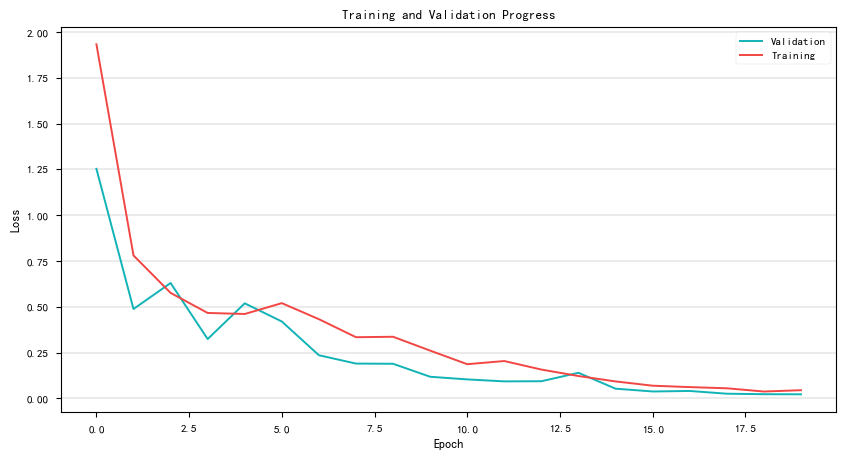

In [22]:
# 构造参数字典
params5 = {
    "train_args": {
        "model_name": TimesNet,
        "train_loader": data_loader,
        "valid_loader": data_loader,
        "n_epochs": 20,
        "learning_rate": 0.001,
        "loss": nn.CrossEntropyLoss(),
        "patience": 5,
        "lradj": 'cosine',
        "model_path": "../outputs/best_models/TimesNet_C",
        "device": 'cuda',
        "verbose": True,
        "plots": True,
    },
    "model_args": {
        'seq_len': data_set.max_seq_len,
        'pred_len': 0,
        'top_k': 3,
        'd_model': 32,
        'num_kernels': 6,
        'embed': 'fixed',
        'freq': 't',
        'd_ff': 32,
        'dropout': 0.1,
        'e_layers': 2,
        'enc_in': 1,
        'num_class': len(data_set.class_names),
    },
}
model = train(**params5)

### 模型测试

In [23]:
def test(test_args):
    # 参数配置
    model = test_args['model']
    test_loader = test_args['test_loader']  # 测试集
    device = test_args['device']  # 可选'cuda'和'cpu'
    test_path = test_args['test_path']  # 结果保存路径

    #检查是否可用GPU
    device = torch.device(device)

    # 设置结果保存路径
    if not os.path.exists(test_path):
        os.makedirs(test_path)

    # 关闭自动求导功能
    model.eval()
    preds = []
    trues = []

    # 测试集
    with torch.no_grad():
        for batch_x, batch_y, mask_x in test_loader:
            #将数据移至 GPU
            batch_x = batch_x.to(device) 
            batch_y = batch_y.to(device) 
            mask_x = mask_x.to(device)
            outputs = model(batch_x, mask_x)
            # 结果汇总
            preds.append(outputs.detach())
            trues.append(batch_y)

    preds = torch.cat(preds, 0)
    trues = torch.cat(trues, 0)
    probs = torch.nn.functional.softmax(preds)  # (total_samples, num_classes) est. prob. for each class and sample
    predictions = torch.argmax(probs, dim=1).cpu().numpy()  # (total_samples,) int class index for each sample
    trues = trues.flatten().cpu().numpy()
    
    # 计算准确率
    accuracy = np.mean(predictions == trues)
    print('accuracy:{}'.format(accuracy))
    
    # 结果保存
    f = open(test_path + "/result_classification.txt", 'a')
    f.write('accuracy:{}'.format(accuracy))
    f.write('\n')
    f.close()

    return accuracy

In [24]:
data_path = "../data/UWaveGestureLibraryAll_TEST.tsv"
data = pd.read_csv(data_path, sep='\t', header=None)
display(data)

# 重构数据集
params1 = {
    "data": [data.iloc[:, 1:]],
    "columns": ['uWave'],
}
re_data = reconstruction(**params1)
print("x shape: {0}".format(re_data.shape))

# 数据归一化
norm_data = x_scaler.transform(re_data)

# 还原数据集
params3 = {
    "feature": norm_data,
    "target": data.iloc[:, 0].values,
}
redu_data = reduction(**params3)
print("x nums: {0}".format(len(redu_data)))
display(redu_data[0])

# 生成数据集
params4 = {
    "data": redu_data,
    "columns": ['uWave'],
}
data_set = TensorDataset(**params4)
print("data_set: {0}".format(len(data_set)))

test_loader = DataLoader(
    data_set,
    batch_size=16,
    shuffle=True,
    drop_last=False,
    collate_fn=lambda x: collate_fn(x, max_len=data_set.max_seq_len))

,0,1,2,3,4,5,6,7,8,9,...,936,937,938,939,940,941,942,943,944,945
0,5,1.558220,1.558220,1.558220,1.558220,1.558220,1.558220,1.558220,1.558220,1.558220,...,-0.347183,-0.347183,-0.343435,-0.339488,-0.331908,-0.324184,-0.316461,-0.308737,-0.301013,-0.293289
1,1,-0.366691,-0.366691,-0.366691,-0.366691,-0.366691,-0.366691,-0.366691,-0.366691,-0.366691,...,0.967255,0.855289,0.731960,0.595985,0.545891,0.522676,0.522676,0.522676,0.522676,0.522676
2,4,1.508383,1.525653,1.542923,1.560194,1.573130,1.576230,1.577907,1.577907,1.577907,...,-0.564940,-0.474730,-0.398200,-0.343229,-0.288257,-0.233284,-0.178312,-0.123341,-0.344129,-0.069269
3,4,1.302603,1.302603,1.302603,1.302603,1.302603,1.302603,1.302603,1.302603,1.302603,...,1.043708,1.043708,1.043708,1.043708,1.078080,1.113808,1.169696,1.226109,1.282522,1.338935
4,5,1.298827,1.298827,1.298827,1.298827,1.298827,1.298827,1.298827,1.298827,1.298827,...,-0.693610,-0.689914,-0.686217,-0.682520,-0.678824,-0.675127,-0.671430,-0.667734,-0.664037,-0.660340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577,2,0.153018,0.153018,0.153018,0.153018,0.153018,0.153018,0.153018,0.153018,0.153018,...,-0.216137,-0.205711,-0.193397,-0.152663,-0.157728,-0.184273,-0.231706,-0.260382,-0.253144,-0.205711
3578,2,0.149424,0.149424,0.149424,0.149424,0.149424,0.149424,0.179749,0.218188,0.245347,...,0.253125,0.200362,0.147125,0.499371,0.378714,0.378714,0.378714,0.378714,0.378714,0.378714
3579,3,-1.028630,-1.028630,-1.028630,-1.028630,-1.028630,-1.028630,-1.028630,-1.028630,-1.028630,...,0.273096,0.243680,0.214265,0.186846,0.166593,0.159775,0.159775,0.159775,0.159775,0.159775
3580,8,-0.754904,-0.754904,-0.754904,-0.754904,-0.754904,-0.754904,-0.754904,-0.754904,-0.754904,...,-0.439384,-0.413858,-0.388332,-0.359061,-0.309656,-0.258727,-0.207675,-0.164244,-0.131756,-0.106230


x shape: (3384990, 1)
x nums: 1


,0,1,2,3,4,5,6,7,8,9,...,936,937,938,939,940,941,942,943,944,945
0,5.0,0.496765,0.496765,0.496765,0.496765,0.496765,0.496765,0.496765,0.496765,0.496765,...,0.338803,0.338803,0.339114,0.339441,0.340070,0.340710,0.341350,0.341991,0.342631,0.343271
1,1.0,0.337186,0.337186,0.337186,0.337186,0.337186,0.337186,0.337186,0.337186,0.337186,...,0.447773,0.438491,0.428267,0.416994,0.412841,0.410916,0.410916,0.410916,0.410916,0.410916
2,4.0,0.492634,0.494065,0.495497,0.496929,0.498001,0.498258,0.498397,0.498397,0.498397,...,0.320751,0.328229,0.334574,0.339131,0.343688,0.348246,0.352803,0.357360,0.339056,0.361843
3,4.0,0.475574,0.475574,0.475574,0.475574,0.475574,0.475574,0.475574,0.475574,0.475574,...,0.454111,0.454111,0.454111,0.454111,0.456961,0.459923,0.464556,0.469233,0.473909,0.478586
4,5.0,0.475261,0.475261,0.475261,0.475261,0.475261,0.475261,0.475261,0.475261,0.475261,...,0.310084,0.310390,0.310697,0.311003,0.311310,0.311616,0.311922,0.312229,0.312535,0.312842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577,2.0,0.380271,0.380271,0.380271,0.380271,0.380271,0.380271,0.380271,0.380271,0.380271,...,0.349667,0.350532,0.351552,0.354929,0.354509,0.352309,0.348377,0.345999,0.346599,0.350532
3578,2.0,0.379973,0.379973,0.379973,0.379973,0.379973,0.379973,0.382487,0.385674,0.387925,...,0.388570,0.384196,0.379782,0.408984,0.398982,0.398982,0.398982,0.398982,0.398982,0.398982
3579,3.0,0.282310,0.282310,0.282310,0.282310,0.282310,0.282310,0.282310,0.282310,0.282310,...,0.390226,0.387787,0.385349,0.383075,0.381396,0.380831,0.380831,0.380831,0.380831,0.380831
3580,8.0,0.305002,0.305002,0.305002,0.305002,0.305002,0.305002,0.305002,0.305002,0.305002,...,0.331160,0.333276,0.335392,0.337819,0.341914,0.346136,0.350369,0.353969,0.356663,0.358779


data_set: 3582


In [25]:
# 构造参数字典
params6 = {
    "test_args": {
        "model": model,
        "test_loader": test_loader,
        'device': 'cuda',
        'test_path': '../outputs/results/TimesNet_C'
    }
}
accuracy = test(**params6)

accuracy:0.9179229480737019


### 模型预测

In [26]:
data_path = "../data/UWaveGestureLibraryPart.csv"
ts_data = pd.read_csv(data_path)
ts_data

,time,uWave
0,2024/10/1 0:00,-0.312502
1,2024/10/1 0:01,-0.312502
2,2024/10/1 0:02,-0.312502
3,2024/10/1 0:03,-0.312502
4,2024/10/1 0:04,-0.312502
...,...,...
995,2024/10/1 16:35,1.443259
996,2024/10/1 16:36,1.443259
997,2024/10/1 16:37,1.443259
998,2024/10/1 16:38,1.443259


In [30]:
def predict(predict_args, model_args):
    # 参数配置
    columns = predict_args['columns'] 
    model_name = predict_args['model_name'] 
    model_path = predict_args['model_path'] 
    x_true = predict_args['x_true'] 
    time_col = predict_args['time_col'] 
    scaler_path = predict_args['scaler_path']
    seq_len = model_args['seq_len']
    device = predict_args['device'] # 可选'cuda'和'cpu'
    
    #检查是否可用GPU
    device = torch.device(device)

    # 读取归一化参数
    x_scaler = joblib.load(scaler_path + "/x_scaler.pkl")

    # 构造数据集
    x_time = x_true[[time_col]] # 获取时间列
    x_true = x_true.copy()[columns]
    x_true[columns] = x_scaler.transform(x_true)
    x_true = x_true.values.astype('float32')
    X_true = []
    for index in range(0, len(x_true) - seq_len + 1):
        # 起点
        s_begin = index
        # 终点(起点 + 回视窗口)
        s_end = s_begin + seq_len
        feat = x_true[s_begin: s_end]
        X_true.append(np.array(feat))
    X_true = torch.as_tensor(X_true).float()
    
    # 创建全是True的掩码
    mask_x = torch.ones(X_true.shape[0], seq_len, dtype=torch.bool)
    
    # 加载模型
    model = model_name(**model_args)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)

    # 模型输出
    model.eval() 
    with torch.no_grad():
        X_true = X_true.to(device)
        mask_x = mask_x.to(device)
        y_pred = model(X_true, mask_x)
    probs = torch.nn.functional.softmax(y_pred)
    predictions = torch.argmax(probs, dim=1).cpu().numpy()
        
    # 输出为Dataframe
    y = pd.DataFrame(data=predictions, columns=['label'])
    result = pd.concat([x_time.iloc[seq_len-1:, :].reset_index(drop=True), y], axis=1)
        
    return result

In [31]:
# 构造参数字典
params6 = {
    "predict_args": {
        "time_col": 'time',
        "columns": ['uWave'],
        "model_name": TimesNet,
        "model_path": "../outputs/best_models/TimesNet_C/checkpoint.pth",
        'x_true': ts_data,
        "scaler_path": '../outputs/scalers/TimesNet_C',
        "device": 'cpu'
    },
    "model_args": {
        'seq_len': 945,
        'pred_len': 0,
        'top_k': 3,
        'd_model': 32,
        'num_kernels': 6,
        'embed': 'fixed',
        'freq': 't',
        'd_ff': 32,
        'dropout': 0.1,
        'e_layers': 2,
        'enc_in': 1,
        'num_class': 8,
    },
}
y_pred = predict(**params6)

In [32]:
y_pred

,time,label
0,2024/10/1 15:44,5
1,2024/10/1 15:45,5
2,2024/10/1 15:46,5
3,2024/10/1 15:47,5
4,2024/10/1 15:48,5
5,2024/10/1 15:49,5
6,2024/10/1 15:50,5
7,2024/10/1 15:51,5
8,2024/10/1 15:52,5
9,2024/10/1 15:53,5
